In [4]:
from datetime import datetime,timedelta

import os
os.chdir('Python')
#from past_features import *
#from elo_features import *
#from categorical_features import *
#from stategy_assessment import *
from utilities import *
#from additional_stuff import *
os.chdir('../')

import pandas as pd

# Import data

In [22]:
data = load("Generated Data/atp_data")
features = load("Generated Data/atp_data_features")
feat_gen = load("Generated Data/general_features")
#features=pd.read_csv("../Generated Data/atp_data_features.csv")

In [23]:
#data.groupby(pd.Grouper(key='Date',freq='Y')).agg('count')
feat_gen.head()

,generalft0,generalft1,generalft2,generalft3,generalft4,generalft_3000,generalft_3001,generalft_3002,generalft_3003,generalft_3004
0,11,48,37,0,12,11,48,37,0,10
1,48,11,-37,1,51,48,11,-37,1,35
2,90,187,97,0,85,90,187,97,0,58
3,187,90,-97,1,154,187,90,-97,1,93
4,98,70,-28,1,66,98,70,-28,1,48


# Noramalizing

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(copy=False)

In [17]:
def skd(data):
    print(features.shape[0])
    
skd(data)

31748


In [21]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31748 entries, 0 to 31747
Data columns (total 23 columns):
ATP           31748 non-null int64
Location      31748 non-null object
Tournament    31748 non-null object
Date          31748 non-null datetime64[ns]
Series        31748 non-null object
Court         31748 non-null object
Surface       31748 non-null object
Round         31748 non-null object
Best of       31748 non-null int64
Winner        31748 non-null object
Loser         31748 non-null object
WRank         31748 non-null int64
LRank         31748 non-null int64
Wsets         31546 non-null float64
Lsets         31544 non-null float64
Comment       31748 non-null object
PSW           28821 non-null float64
PSL           28821 non-null float64
B365W         31571 non-null float64
B365L         31594 non-null float64
elo_winner    31748 non-null float64
elo_loser     31748 non-null float64
proba_elo     31748 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(4), o

# splitting and cleaning

In [13]:
#start_date=datetime.datetime(2013,1,1) #first day of testing set
start_date=datetime(2013,1,1) #first day of testing set
test_beginning_match=data[data.Date==start_date].index[0] #id of the first match of the testing set
span_matches=len(data)-test_beginning_match+1
duration_val_matches=500
duration_train_matches=10400
duration_test_matches=2000

In [14]:
def split_and_clean(features_raw, data, duration_train_matches, 
                    duration_val_matches,duration_test_matches, 
                    span_matches,test_beginning_match, odded=0, scaler=None):
    '''
    Scaling the features before splitting
    Splitting the features in the sets
    cleaning for NaN
    
    Some classifiers desire scaled features
    some classifiers do not accept NaN
    And there is the question if the odds should influence the opinion of the models, 
    so you can decide if odds should be considered, or not. 
    '''
    
    #scale and normalizing
    if scaler != None:
        features = pd.DataFrame(scaler.fit_transform(features_raw), columns = features_raw.columns)
    else:
        features = features_raw
    
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches

    train_indices=range(2*beg_train,2*end_train+2)
    val_indices=range(2*beg_val,2*end_val+2)
    test_indices=range(2*beg_test,2*end_test+2)
    print([train_indices, val_indices, test_indices])
    
    # Split in train/validation/test
    xval=features.iloc[val_indices,:].reset_index(drop=True)
    xtest=features.iloc[test_indices,:].reset_index(drop=True)
    xtrain=features.iloc[train_indices,:].reset_index(drop=True)
    ytrain=pd.Series([1,0]*int(len(train_indices)/2))
    yval=pd.Series([1,0]*int(len(val_indices)/2))
    ytest=pd.Series([1,0]*int(len(test_indices)/2))
    
    # make the dataset with or without odds
    if odded:
        cols_to_drop = ['duoft3','playerft53', 'playerft57', 'duoft_3003']
        cols_to_clean = ['odds','recentft0', 'recentft1','recentft2','recentft3','recentft4','recentft5','recentft6',
                'recentft_3000', 'recentft_3001','recentft_3002','recentft_3003','recentft_3004','recentft_3005','recentft_3006']
    else:
        cols_to_drop = ['duoft3','playerft53', 'playerft57','odds', 'duoft_3003']
        cols_to_clean = ['recentft0', 'recentft1','recentft2','recentft3','recentft4','recentft5','recentft6',
                'recentft_3000', 'recentft_3001','recentft_3002','recentft_3003','recentft_3004','recentft_3005','recentft_3006']
        
    def row_clean(df, ctc):
        lines_to_drop = []
        for i in ctc:
            aff_rows = df.loc[pd.isna(df[i]), :].index 
            lines_to_drop.extend(aff_rows)
        return list(set(lines_to_drop))
    
    # cleaning data
    xtrain_na_free  =  xtrain.drop(cols_to_drop, axis = 1)
    xval_na_free  =  xval.drop(cols_to_drop, axis = 1)
    xtest_na_free  =  xtest.drop(cols_to_drop, axis = 1)

    xtrain_na_only_ind = row_clean(xtrain_na_free,cols_to_clean)
    xtrain_na_free = xtrain_na_free.drop(xtrain_na_only_ind,axis=0)
    ytrain_na_free = ytrain.drop(xtrain_na_only_ind,axis=0)

    xval_na_only_ind = row_clean(xval_na_free,cols_to_clean)
    xval_na_free = xval_na_free.drop(xval_na_only_ind,axis=0)
    yval_na_free = yval.drop(xval_na_only_ind,axis=0)

    xtest_na_only_ind = row_clean(xtest_na_free,cols_to_clean)
    xtest_na_free = xtest_na_free.drop(xtest_na_only_ind,axis=0)
    ytest_na_free = ytest.drop(xtest_na_only_ind,axis=0)

    print(f'Lenght "xtrain" before: {xtrain.shape[0]}; after: {xtrain_na_free.shape[0]}; diminution: {len(xtrain_na_only_ind)}')
    print(f'Lenght "xval" before: {xval.shape[0]}; after: {xval_na_free.shape[0]}; diminution: {len(xval_na_only_ind)}')
    print(f'Lenght "xtest" before: {xtest.shape[0]}; after: {xtest_na_free.shape[0]}; diminution: {len(xtest_na_only_ind)}')
    
    return xtrain_na_free, ytrain_na_free

In [15]:
xtrain, ytrain = split_and_clean(features, data, 
                                 duration_train_matches,
                                 duration_val_matches,
                                 duration_test_matches, 
                                 span_matches,
                                 test_beginning_match, 
                                 odded=0, 
                                 scaler = None)

NameError: name 'features' is not defined

In [12]:
xtrain, ytrain = split_and_clean(features, data, 
                                 duration_train_matches,
                                 duration_val_matches,
                                 duration_test_matches, 
                                 span_matches,
                                 test_beginning_match, 
                                 odded=0, 
                                 scaler = scaler)

[range(5114, 25914), range(25914, 26914), range(26914, 30914)]
Lenght "xtrain" before: 20800; after: 19564; diminution: 1236
Lenght "xval" before: 1000; after: 963; diminution: 37
Lenght "xtest" before: 4000; after: 3762; diminution: 238


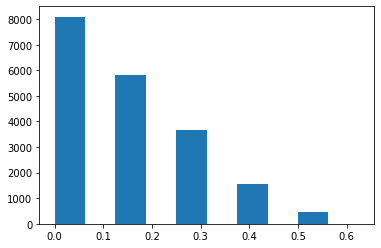

In [92]:
feat = xtrain.playerft52

plt.hist(feat);

# Grid searching

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

In [24]:
# GS_ABC_6
print('run')
#'log_loss', 'precision'
scores = {'auc':'roc_auc', 'preci':'precision'}
parameters = {'learning_rate':[0.01,0.05,1, 1.5], 'base_estimator__l1_ratio':[0]}
lrc = LogisticRegression(random_state=0, multi_class = 'ovr', verbose=10)
#lrc = LogisticRegression(random_state=0,penalty='elasticnet',solver = 'saga', multi_class = 'ovr', verbose=10)
ada_model=AdaBoostClassifier(base_estimator=lrc, n_estimators = 50)

grid_search_ABC_6 = GridSearchCV(ada_model, param_grid=parameters,scoring = scores,refit='auc', verbose = 20, n_jobs = -1)

grid_search_ABC_6.fit(xtrain,ytrain)

run
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  3.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  17 out o

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jo

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=LogisticRegression(C=1.0,
                                                                            class_weight=None,
                                                                            dual=False,
                                                                            fit_intercept=True,
                                                                            intercept_scaling=1,
                                                                            l1_ratio=None,
                                                                            max_iter=100,
                                                                            multi_class='ovr',
                                                                            n_jobs=None,
                                                                          

In [25]:
res3 = pd.DataFrame(grid_search_ABC_6.cv_results_)

In [26]:
res3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__l1_ratio,param_learning_rate,params,split0_test_auc,split1_test_auc,split2_test_auc,...,std_test_auc,rank_test_auc,split0_test_preci,split1_test_preci,split2_test_preci,split3_test_preci,split4_test_preci,mean_test_preci,std_test_preci,rank_test_preci
0,47.685701,0.983923,0.815561,0.017738,0,0.01,"{'base_estimator__l1_ratio': 0, 'learning_rate...",0.738970,0.747045,0.713337,...,0.014617,4,0.673199,0.683130,0.658309,0.666171,0.675994,0.671361,0.008493,4
1,46.859389,1.170634,0.688964,0.075196,0,0.05,"{'base_estimator__l1_ratio': 0, 'learning_rate...",0.741574,0.749138,0.716058,...,0.014481,3,0.673199,0.683130,0.658309,0.666171,0.676326,0.671427,0.008530,3
2,44.992134,2.001607,0.719186,0.048163,0,1,"{'base_estimator__l1_ratio': 0, 'learning_rate...",0.757146,0.759050,0.733046,...,0.012959,2,0.673689,0.684133,0.661108,0.667824,0.677467,0.672844,0.007905,2
3,44.853042,1.244470,0.635826,0.156318,0,1.5,"{'base_estimator__l1_ratio': 0, 'learning_rate...",0.757836,0.759332,0.734200,...,0.012752,1,0.682796,0.686217,0.667971,0.671260,0.681195,0.677888,0.007024,1
